In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 10 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+2+2, num_feat, num_node+1, deg, e, seed=42)

In [3]:
from model import vrpModel
# demands
demands = np.random.rand(num_node) * 10
# set solver
optmodel = vrpModel(num_node+1, demands=demands, capacity=30, num_vehicle=5)
# solve
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {:.4f}".format(obj))
route = optmodel.getTour(sol)
for tour in route:
    print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 64.0461
0 -> 1 -> 9 -> 12 -> 0
0 -> 3 -> 5 -> 10 -> 0
0 -> 4 -> 16 -> 11 -> 2 -> 8 -> 0
0 -> 7 -> 14 -> 15 -> 18 -> 13 -> 20 -> 6 -> 19 -> 17 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=2, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=2, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 65.99it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.89it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node+1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 3

In [11]:
import copy
import time
from tqdm import tqdm

def pipeline(reg, forward_func, loss_func, lr, num_epochs, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log = []
    grad_log = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    time.sleep(1)
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log


def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 5e-2
loss_log, grad_log = pipeline(reg, forward2S, mse, lr, num_epochs, loader_train_cost, loader_val, loader_test)

Epoch    2, Loss:  79.2370: 100%|████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


Training Elapsed Time: 0.04 Sec

Evaluation:
Test Regret: 114.3523%
Test Elapsed Time: 0.18 Sec


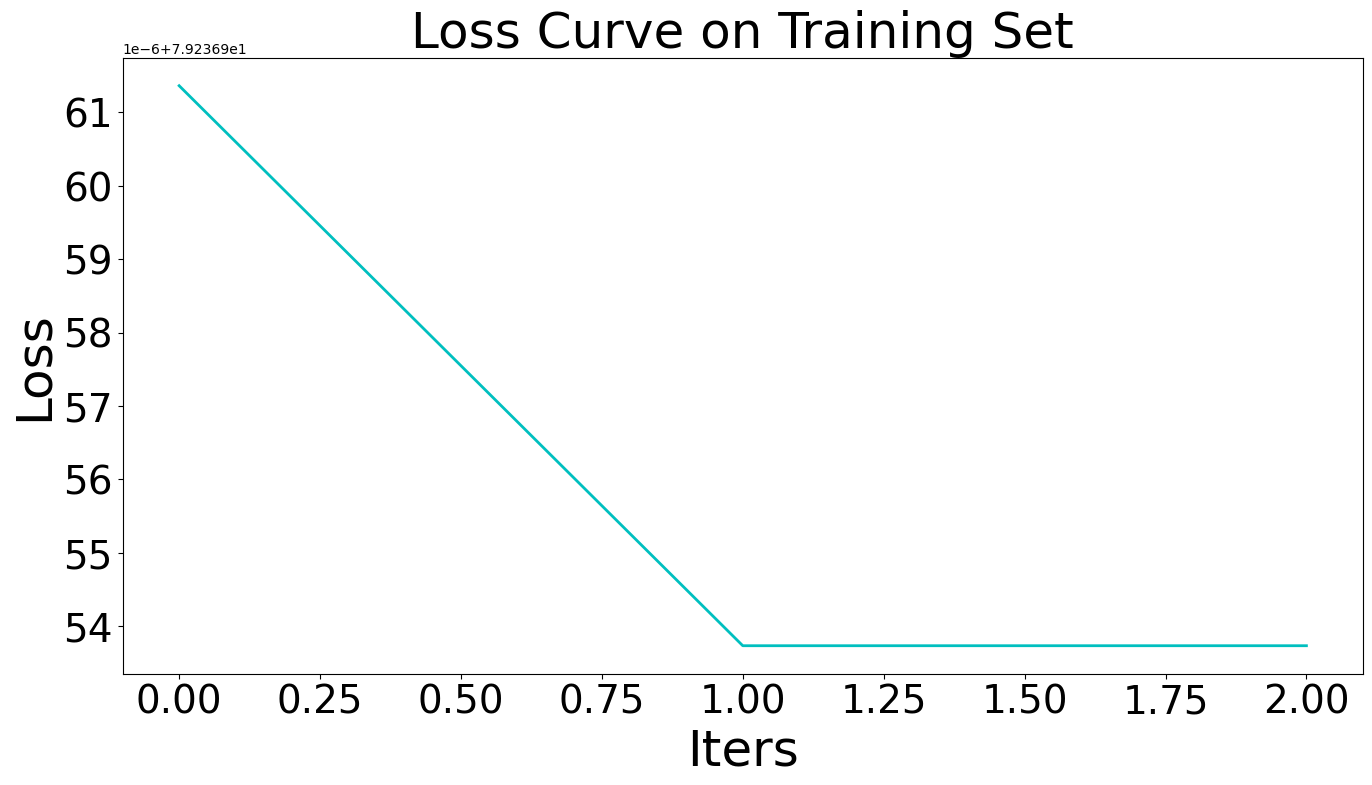

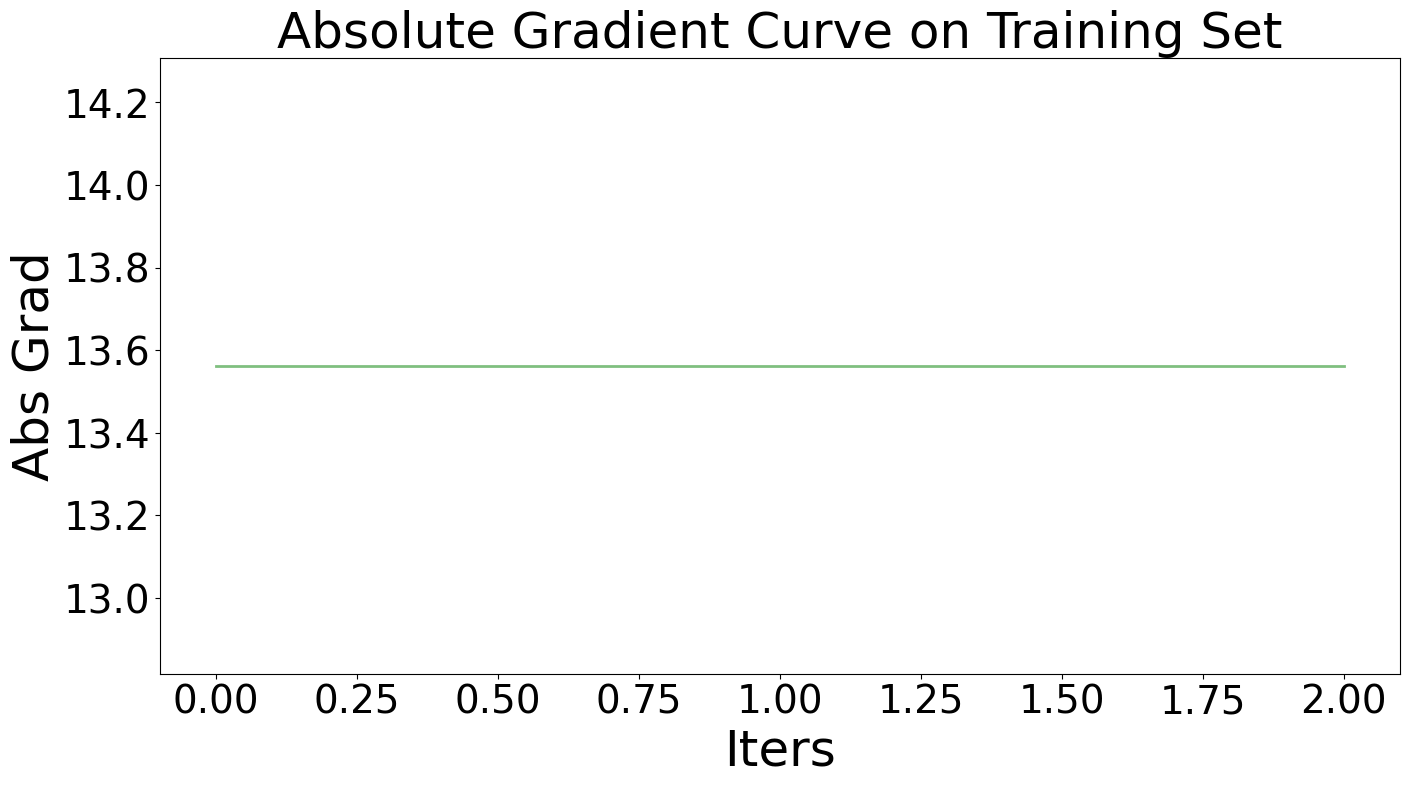

In [15]:
plot(loss_log, grad_log)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_val, loader_test)

Epoch    2, Loss:  -0.8876: 100%|████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.64s/it]


Training Elapsed Time: 4.91 Sec

Evaluation:
Test Regret: 110.0804%
Test Elapsed Time: 0.31 Sec


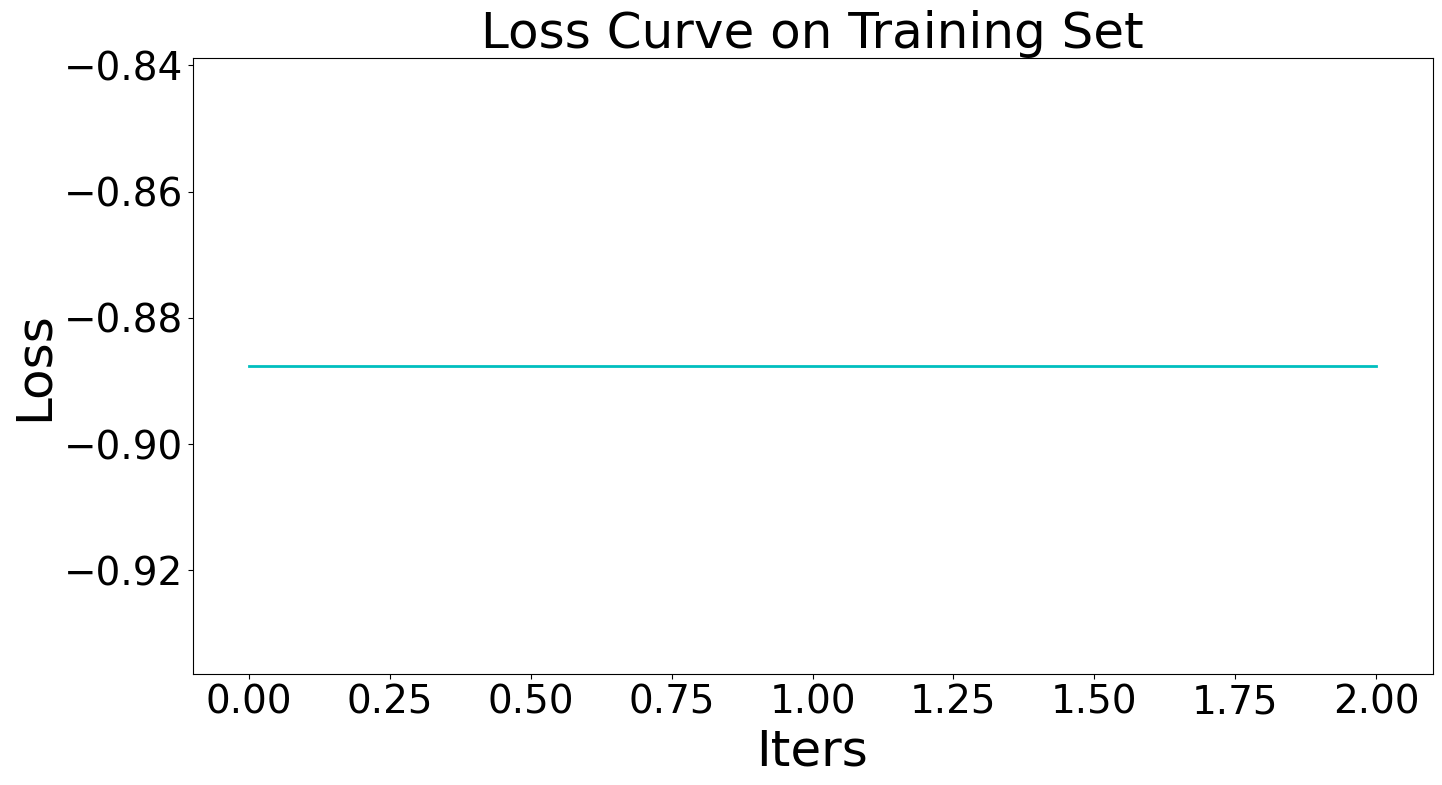

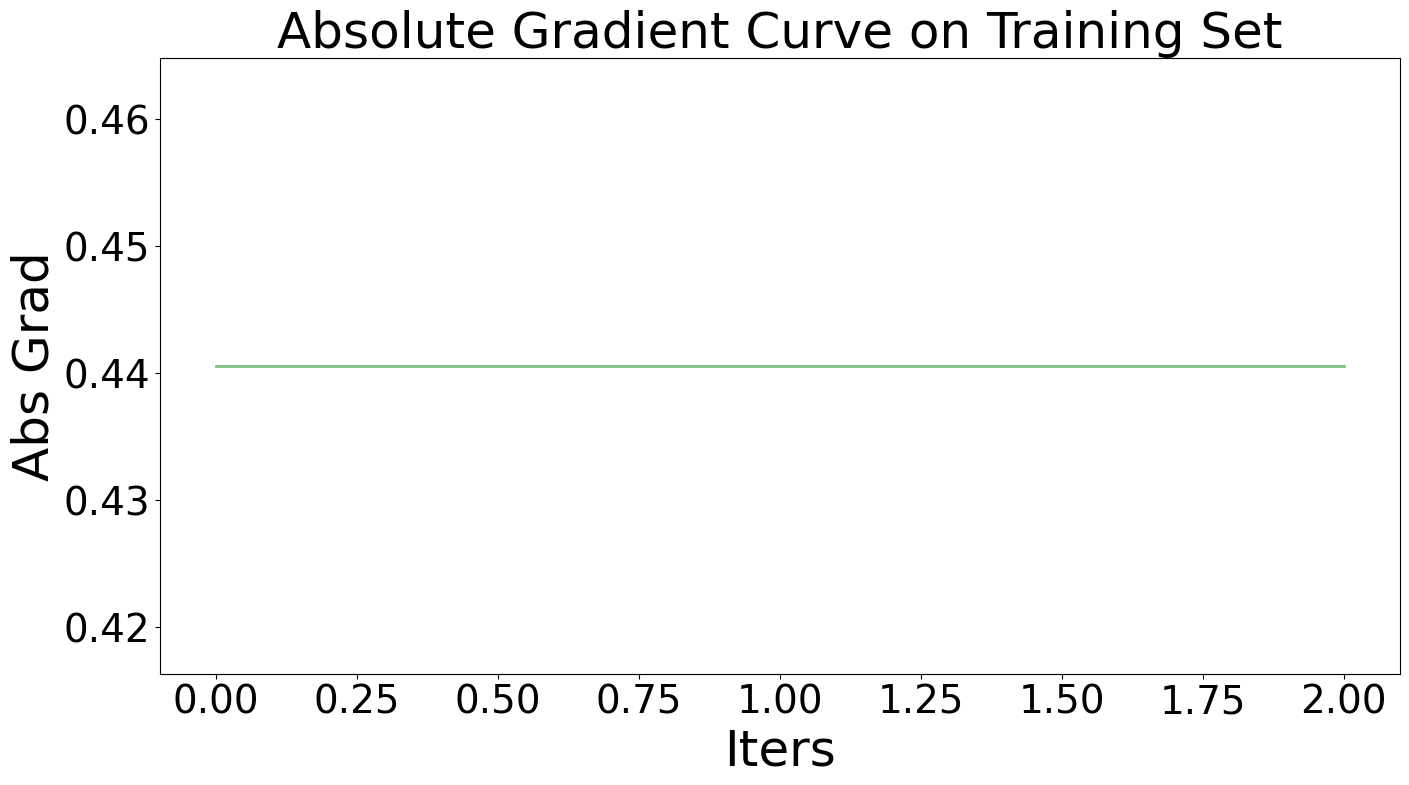

In [19]:
plot(loss_log, grad_log)

### Inner Method with Clarabel

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [22]:
lr = 5e-2
loss_log, grad_log = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_val, loader_test)

Epoch    2, Loss:  -0.7873: 100%|████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


Training Elapsed Time: 0.13 Sec

Evaluation:
Test Regret: 110.0804%
Test Elapsed Time: 0.32 Sec


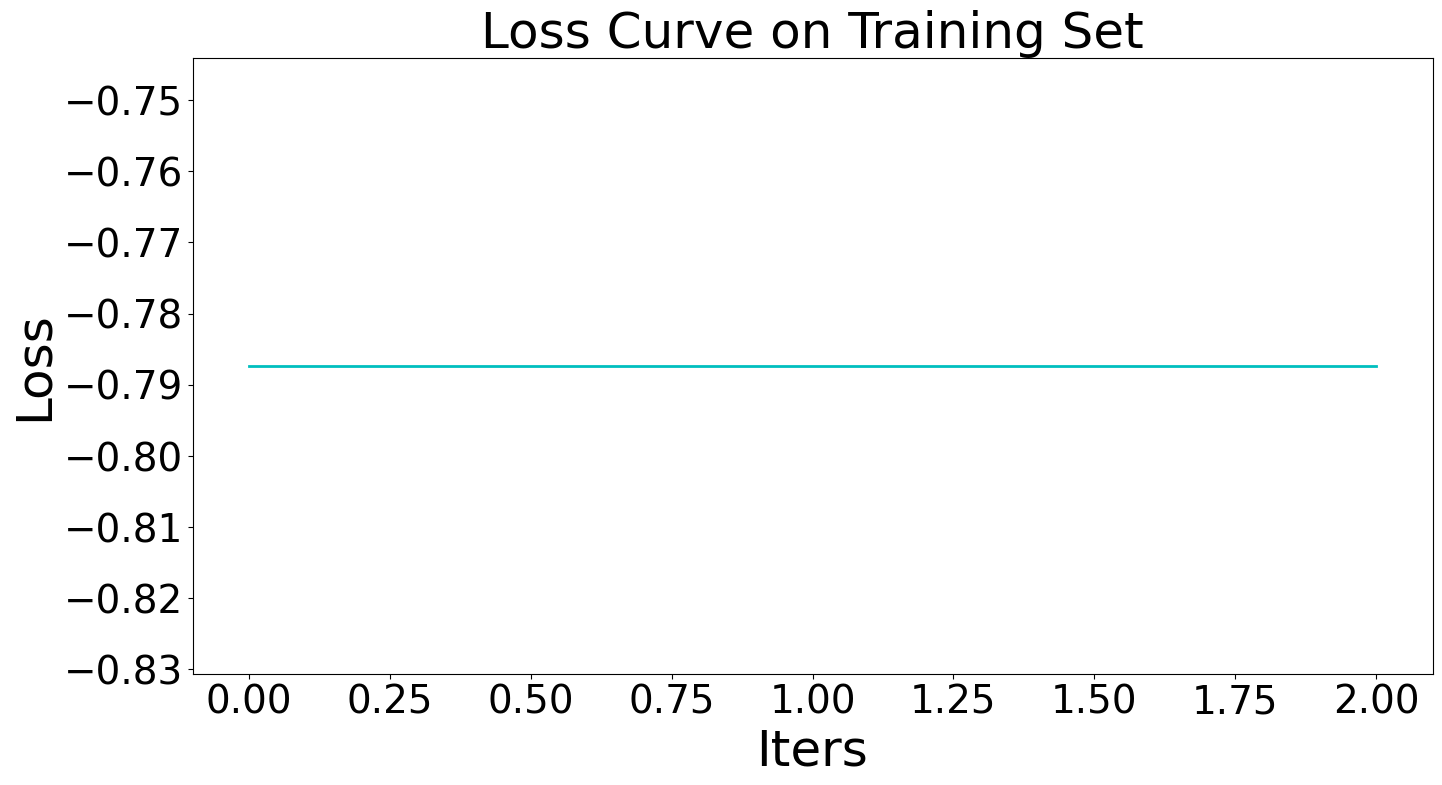

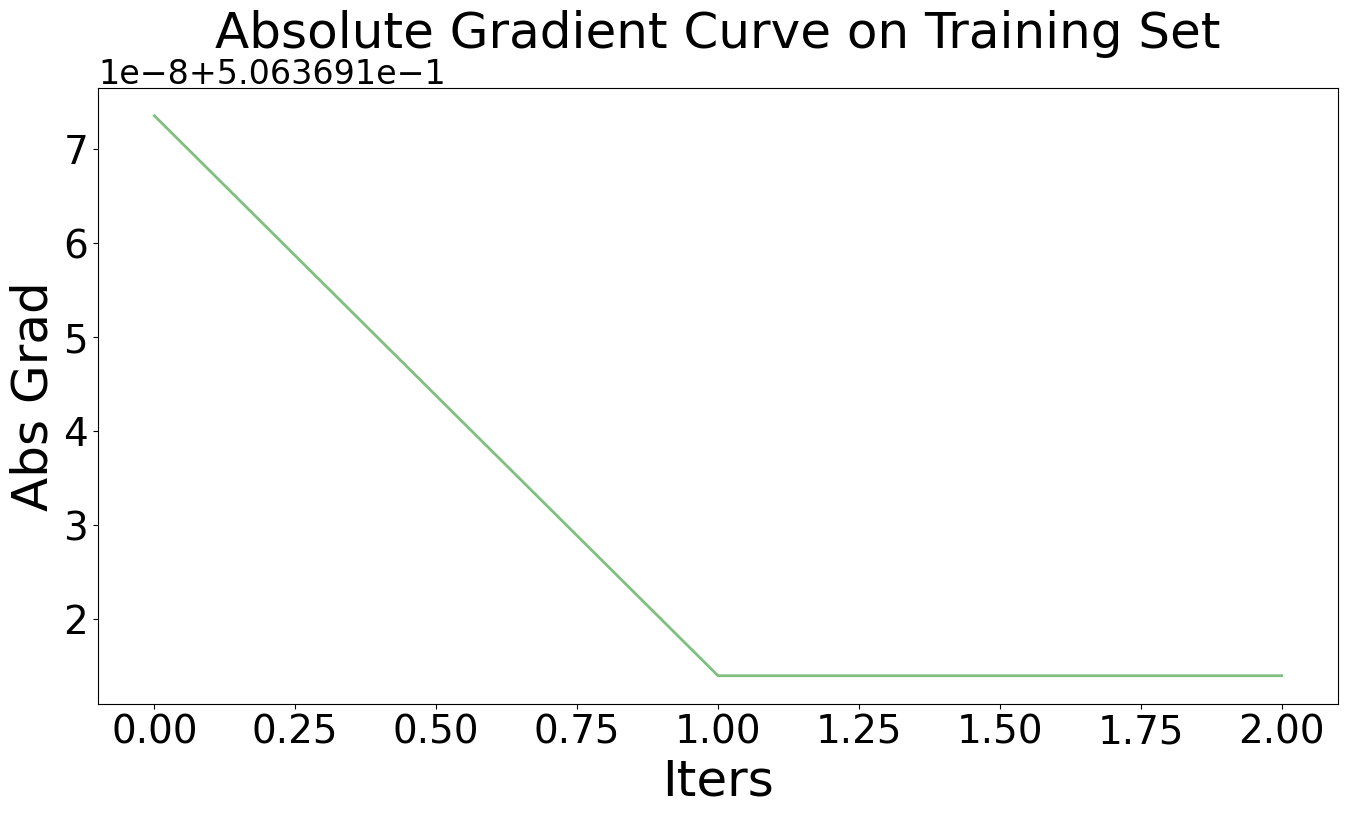

In [23]:
plot(loss_log, grad_log)

### Inner & Average Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", solve_ratio=0.3, processes=8)

Num of cores: 8


In [26]:
lr = 5e-2
loss_log, grad_log = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_val, loader_test)

Epoch    2, Loss:  -0.9998: 100%|████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


Training Elapsed Time: 0.01 Sec

Evaluation:
Test Regret: 110.0804%
Test Elapsed Time: 0.30 Sec


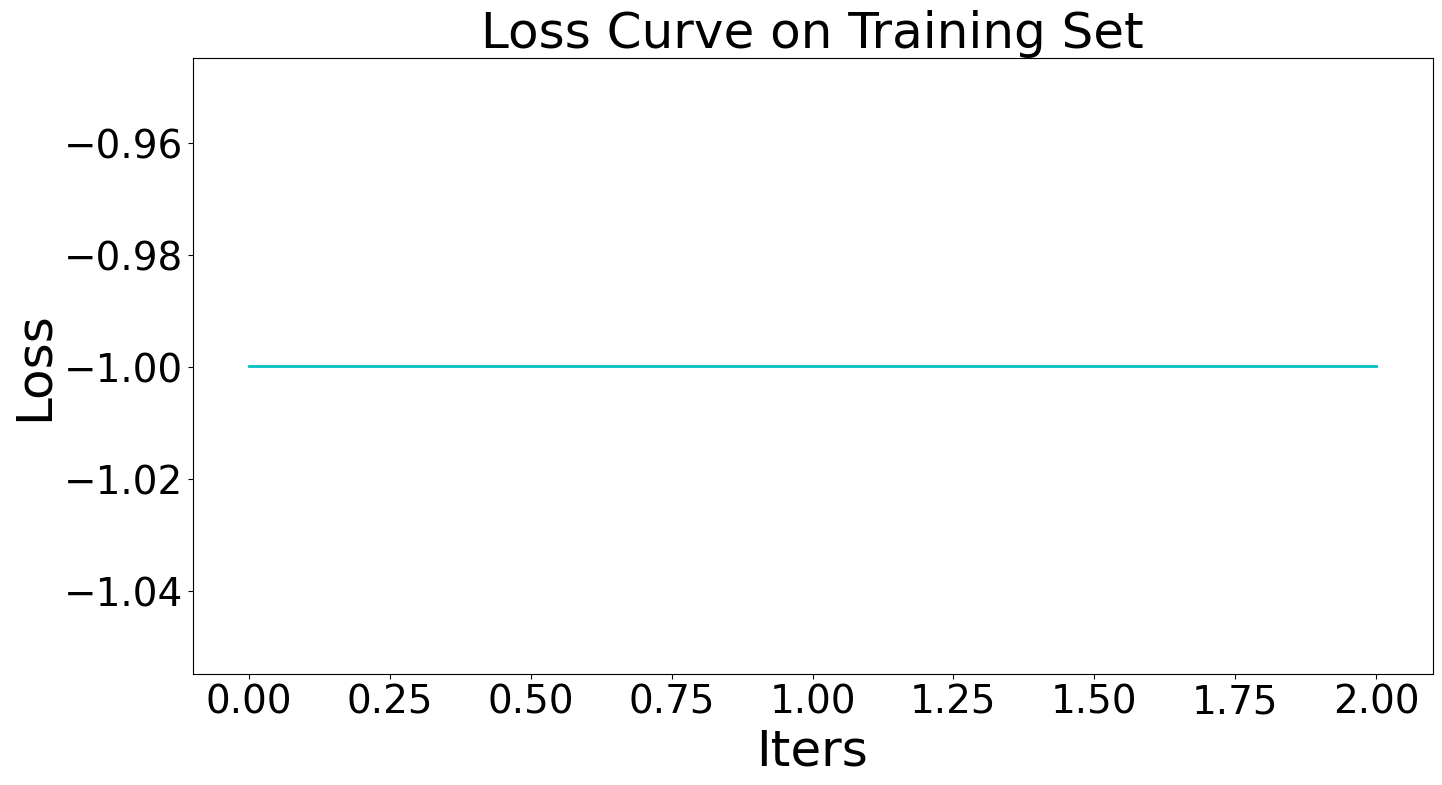

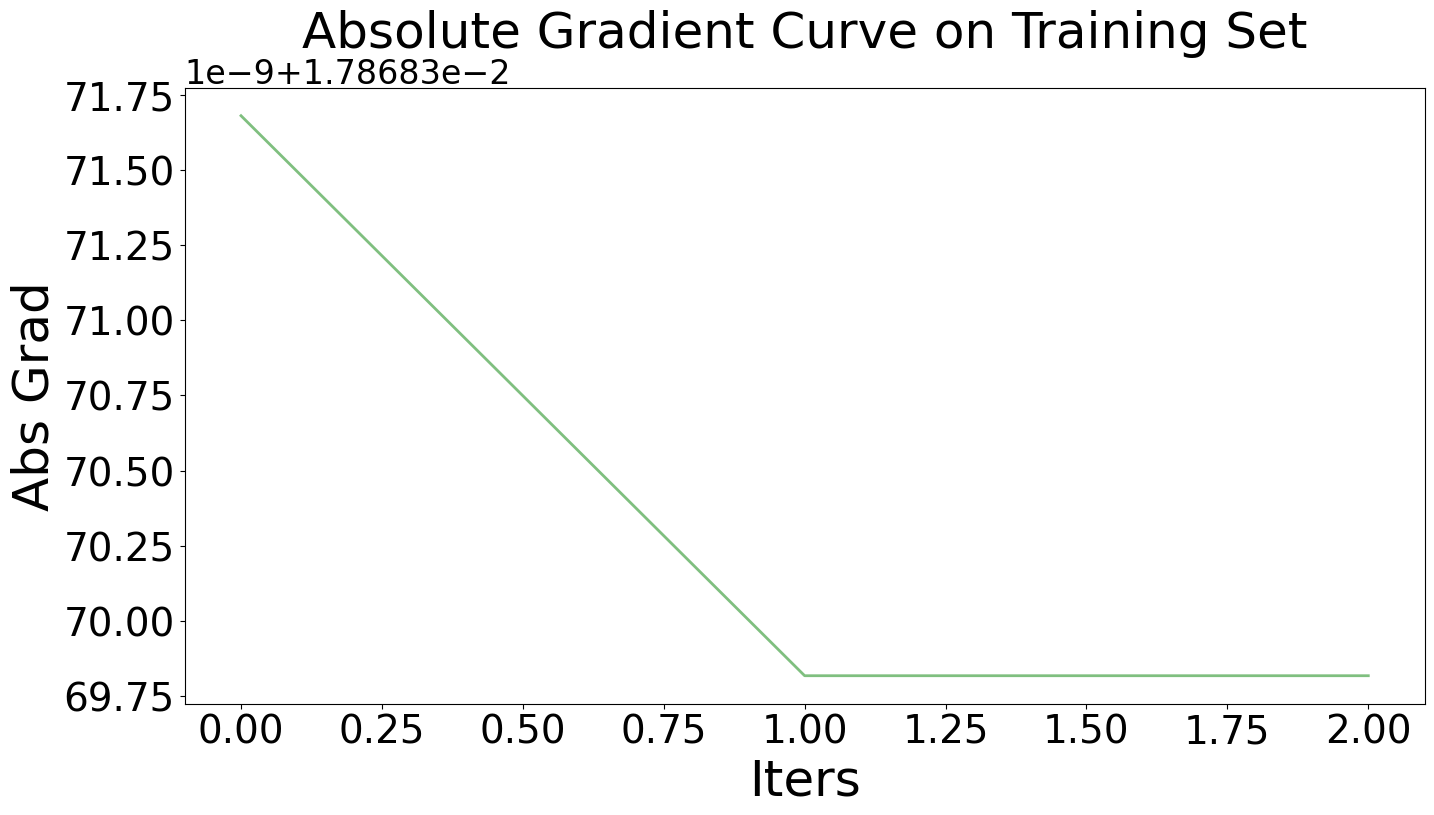

In [27]:
plot(loss_log, grad_log)

### Sampling Method

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4)

Num of cores: 1


In [30]:
lr = 1e-1
loss_log, grad_log = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_val, loader_test)

Epoch    2, Loss:  -0.9989: 100%|████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


Training Elapsed Time: 0.03 Sec

Evaluation:
Test Regret: 110.0804%
Test Elapsed Time: 0.30 Sec


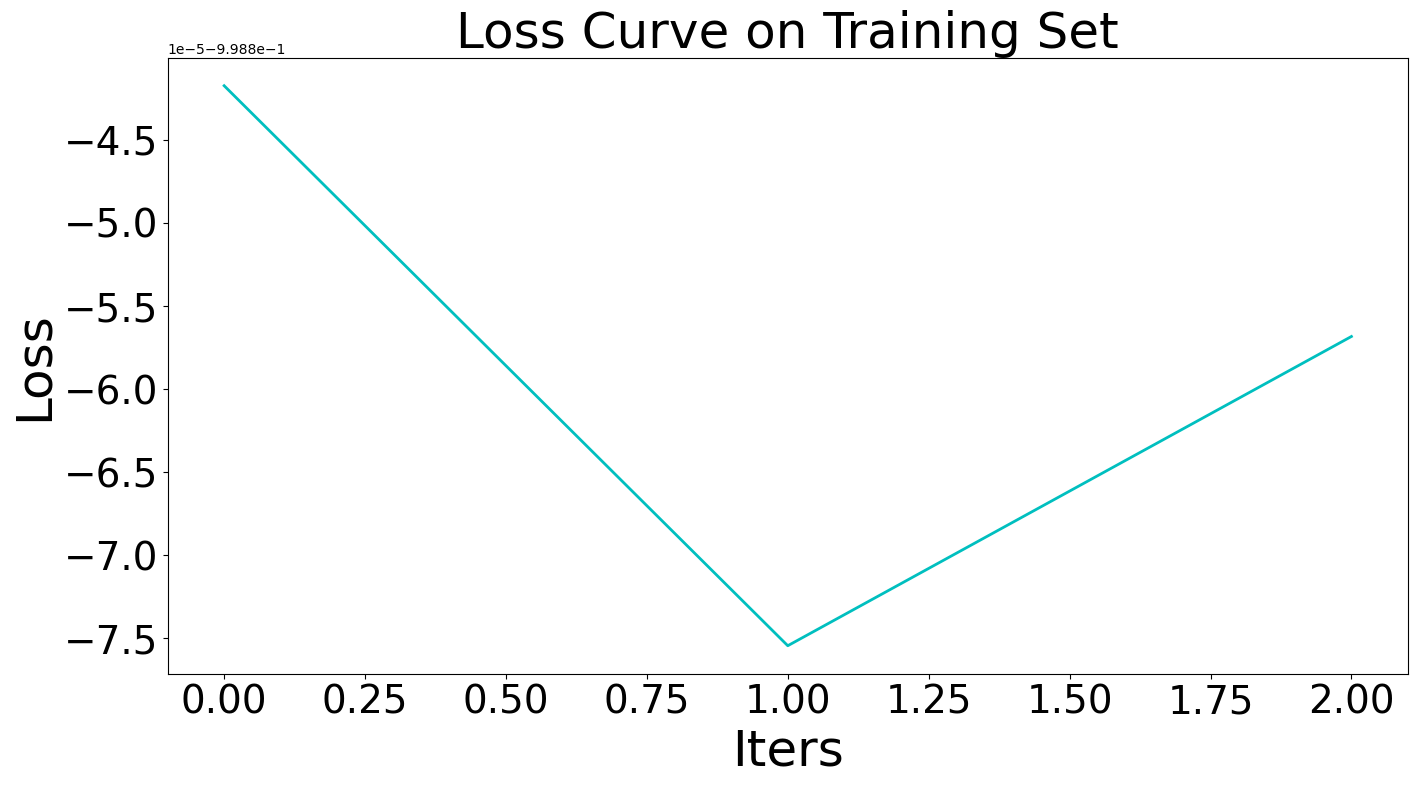

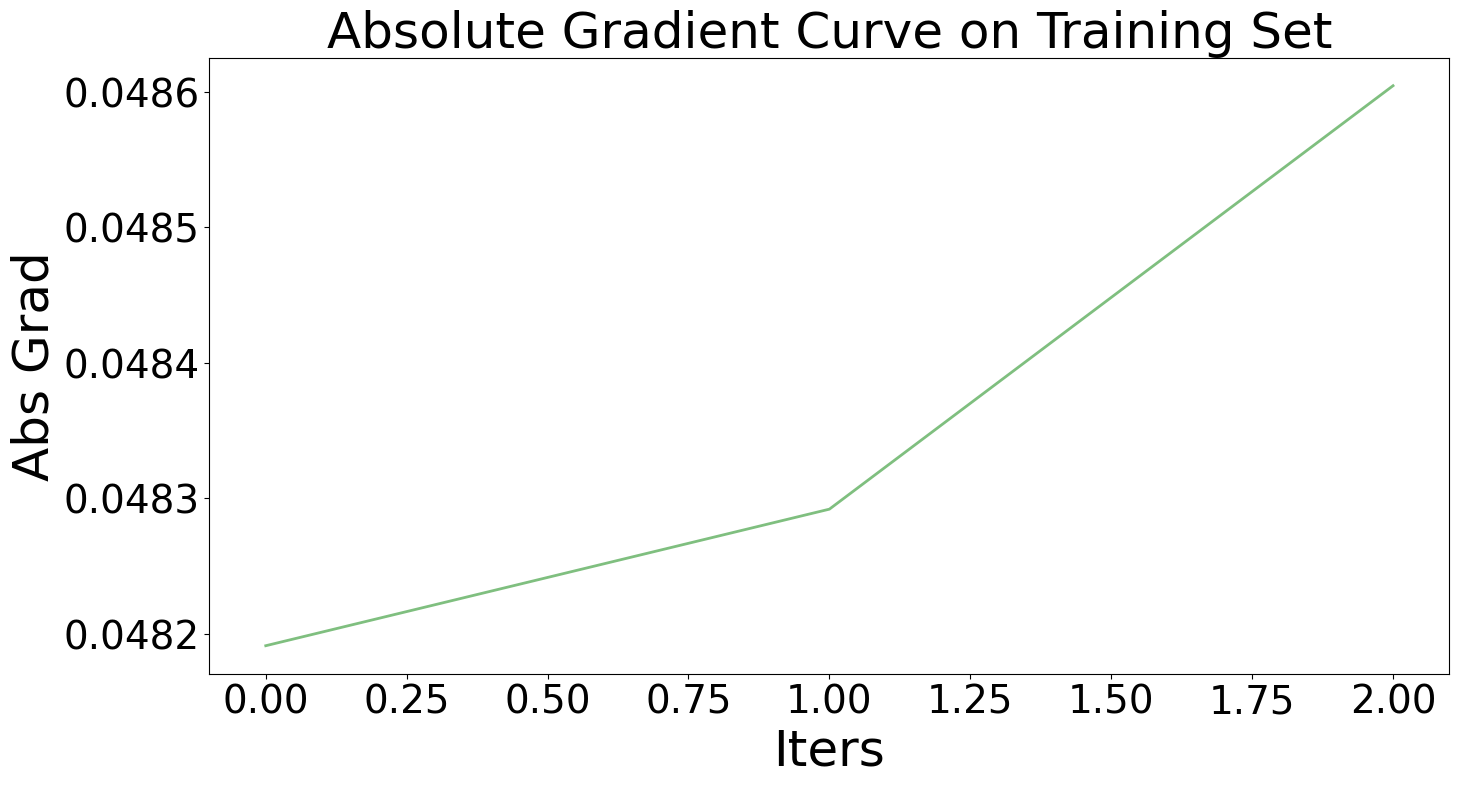

In [31]:
plot(loss_log, grad_log)

### Sampling Method with Cone Check

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4, check_cone=True)

Num of cores: 1


In [34]:
lr = 1e-1
loss_log, grad_log = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_val, loader_test)

Epoch    2, Loss:  -0.9988: 100%|████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


Training Elapsed Time: 0.18 Sec

Evaluation:
Test Regret: 98.8461%
Test Elapsed Time: 0.10 Sec


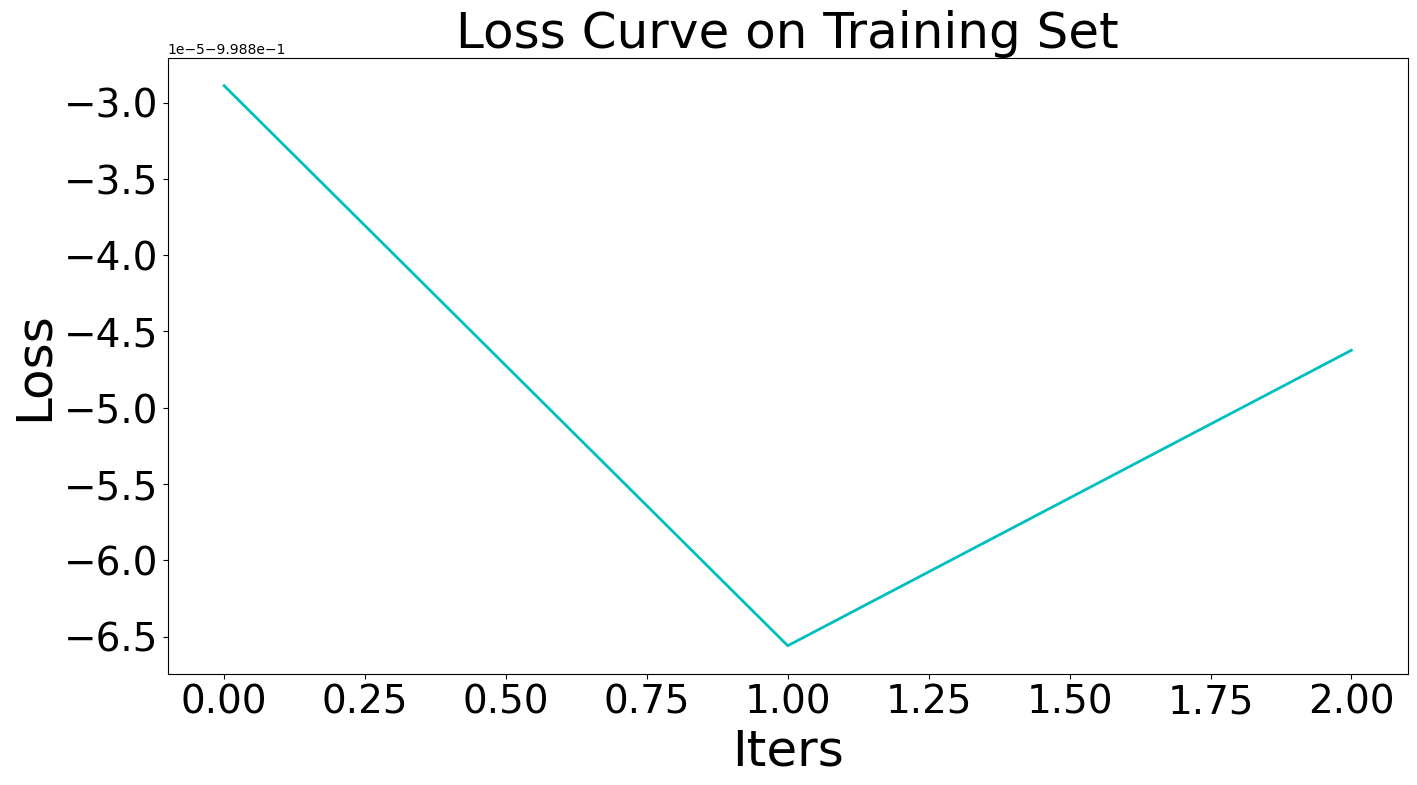

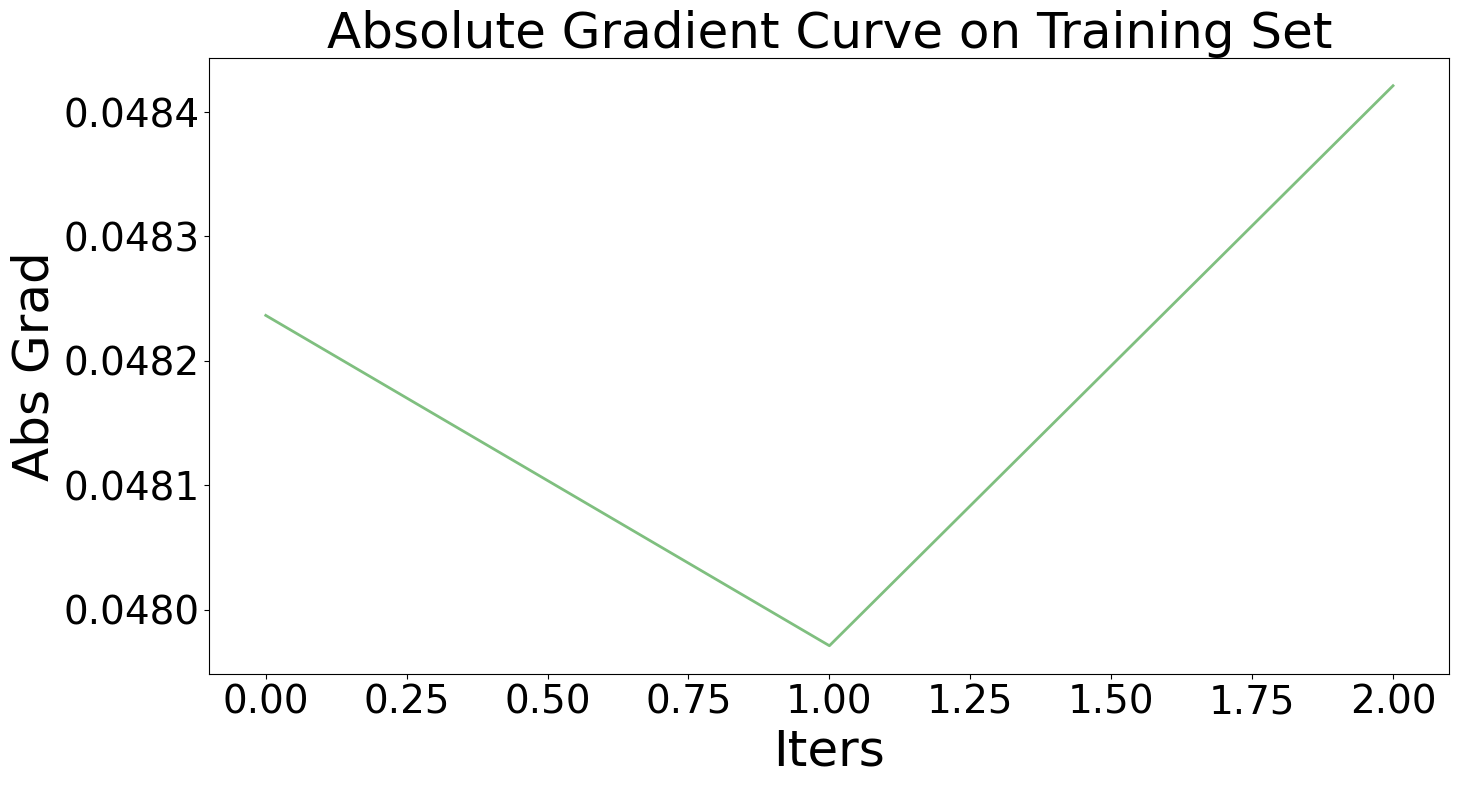

In [35]:
plot(loss_log, grad_log)

### Average Method 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4)

Num of cores: 1


In [38]:
lr = 1e-1
loss_log, grad_log = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_val, loader_test)

Epoch    2, Loss:  -0.9986: 100%|████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.02s/it]


Training Elapsed Time: 0.01 Sec

Evaluation:
Test Regret: 98.8461%
Test Elapsed Time: 0.10 Sec


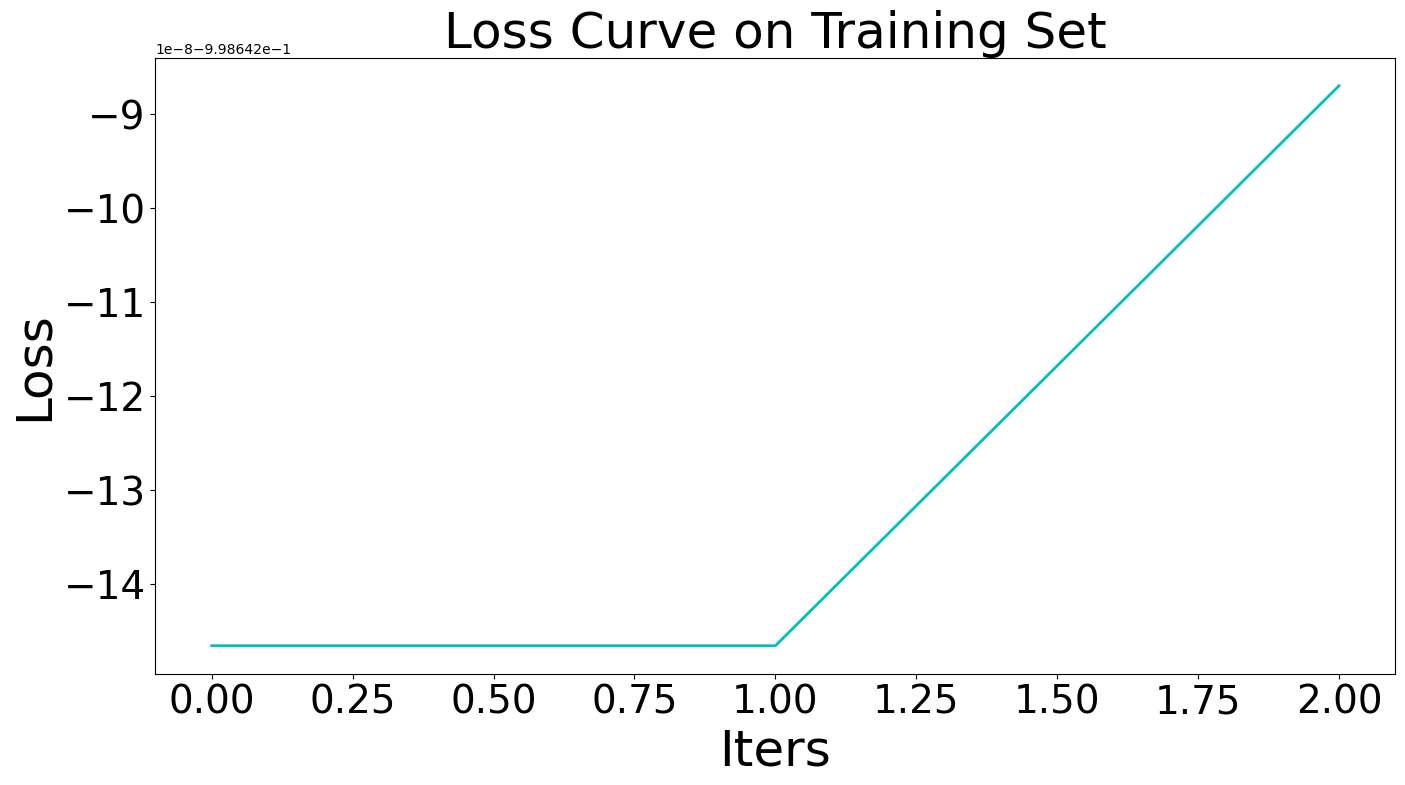

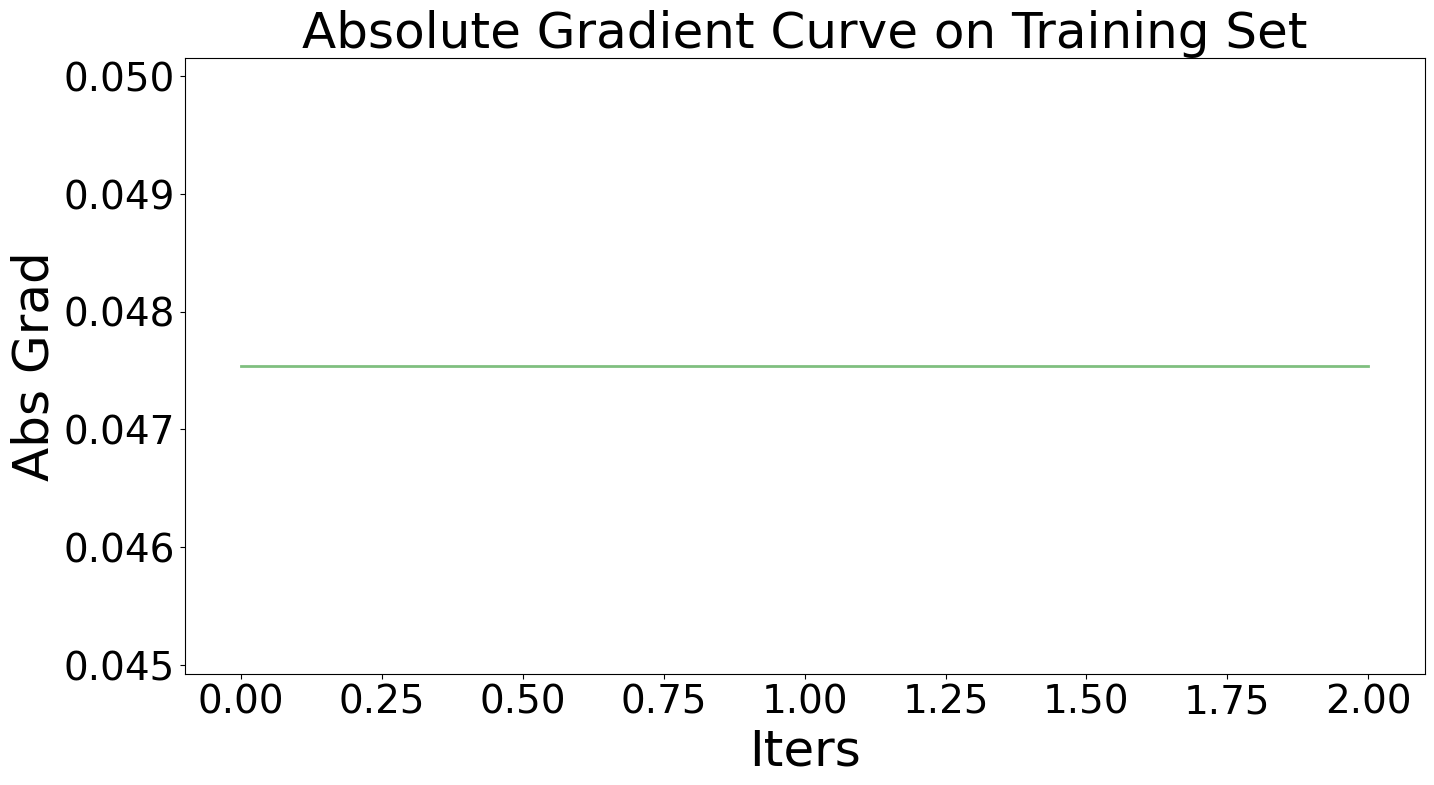

In [39]:
plot(loss_log, grad_log)

###  Average Method with Cone Check

In [40]:
# init model
reg = LinearRegression()

In [41]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4, check_cone=True)

Num of cores: 1


In [42]:
lr = 1e-1
loss_log, grad_log = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_val, loader_test)

Epoch    2, Loss:  -0.9987: 100%|████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/it]


Training Elapsed Time: 0.14 Sec

Evaluation:
Test Regret: 110.0804%
Test Elapsed Time: 0.30 Sec


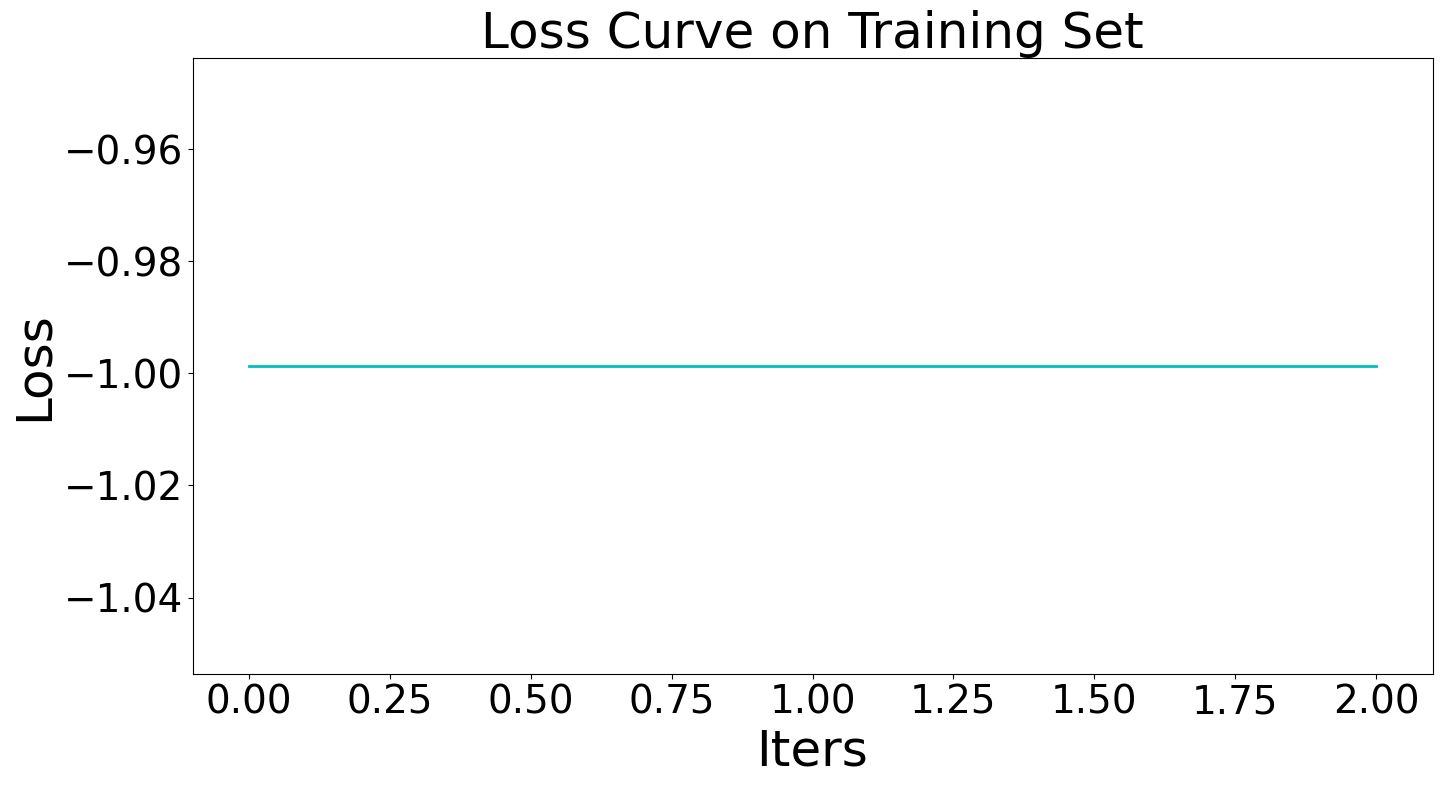

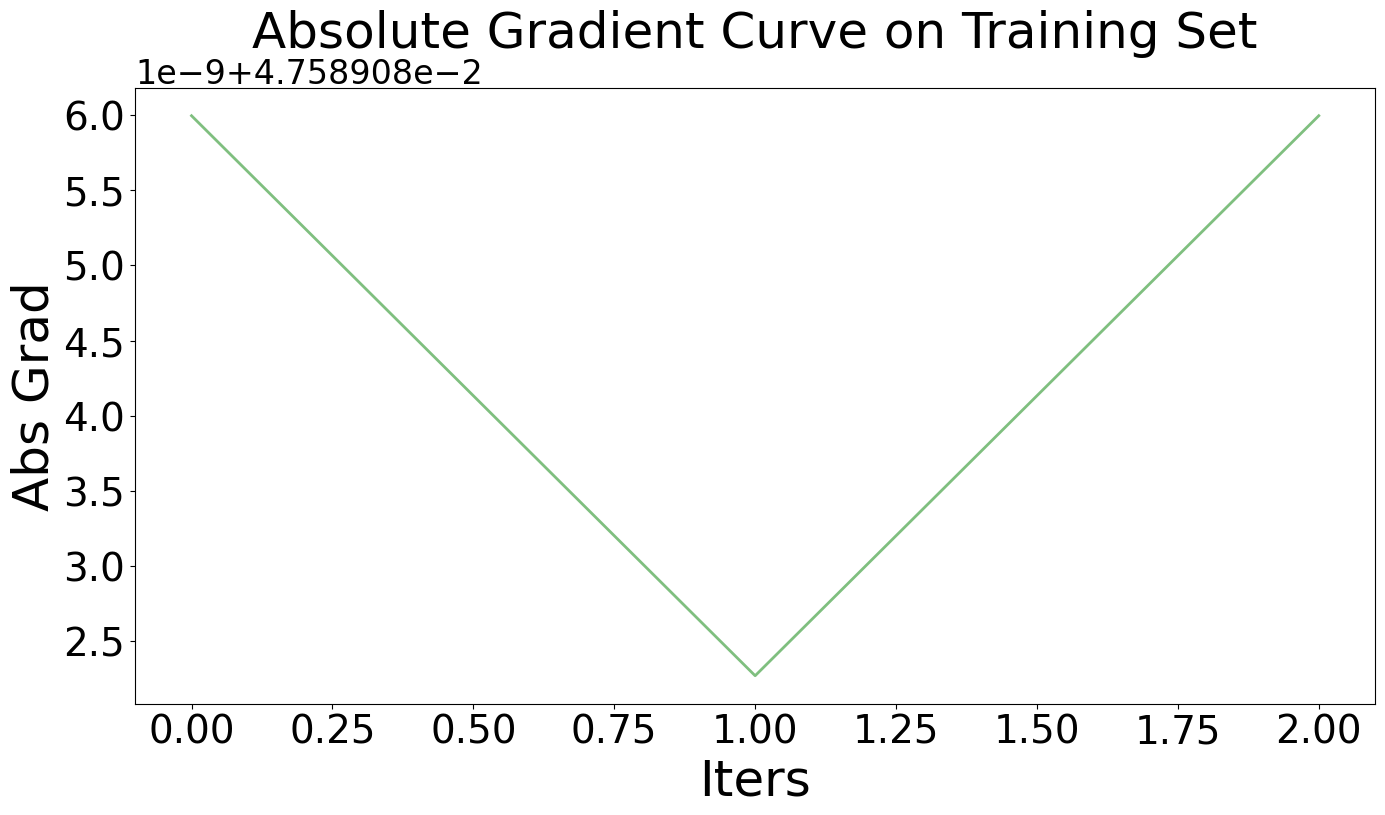

In [43]:
plot(loss_log, grad_log)

### PFYL 

In [44]:
# init model
reg = LinearRegression()

In [45]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [46]:
lr = 5e-2
loss_log, grad_log = pipeline(reg, forwardPFY, pfy, lr, num_epochs, loader_train, loader_val, loader_test)

Epoch    2, Loss:  37.3000: 100%|████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.70s/it]


Training Elapsed Time: 8.07 Sec

Evaluation:
Test Regret: 110.0804%
Test Elapsed Time: 0.30 Sec


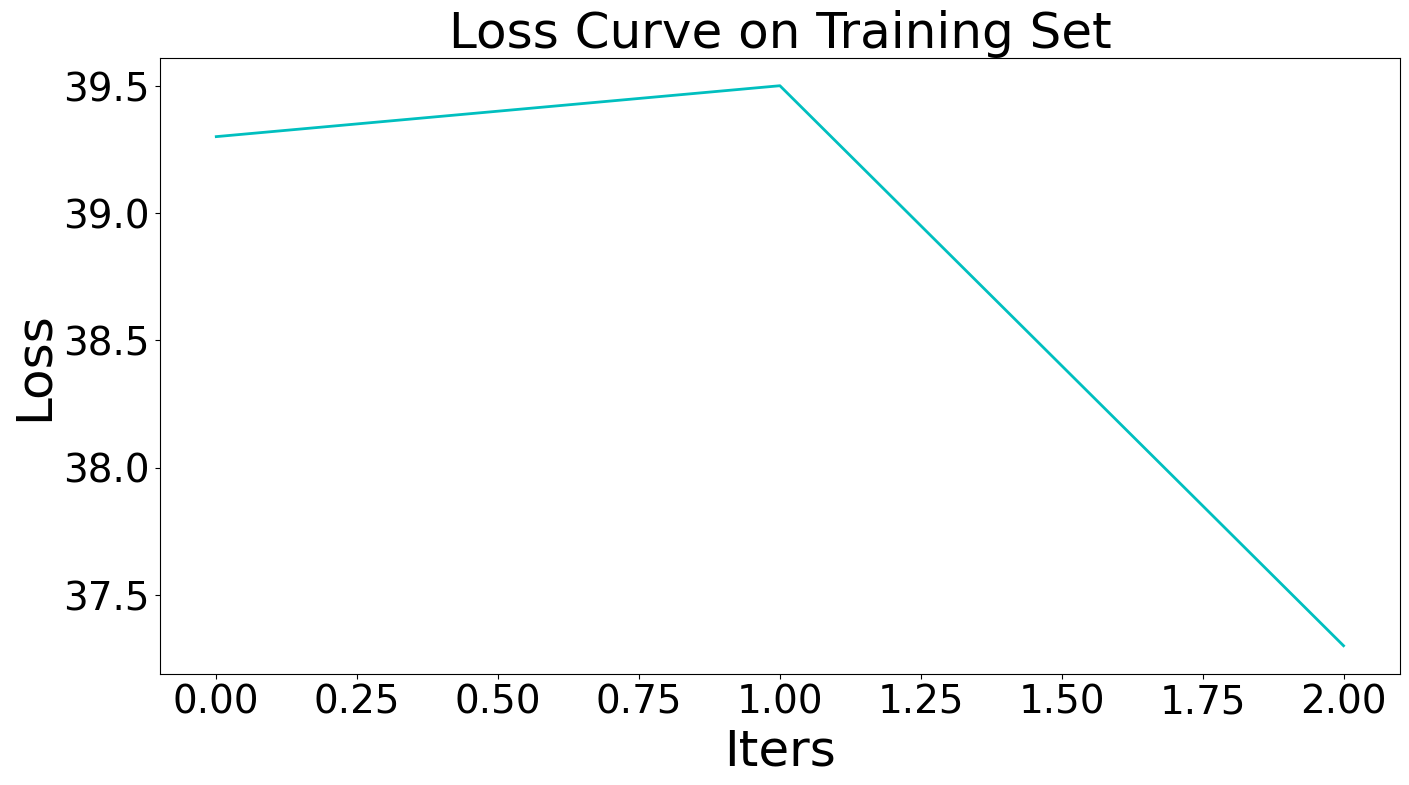

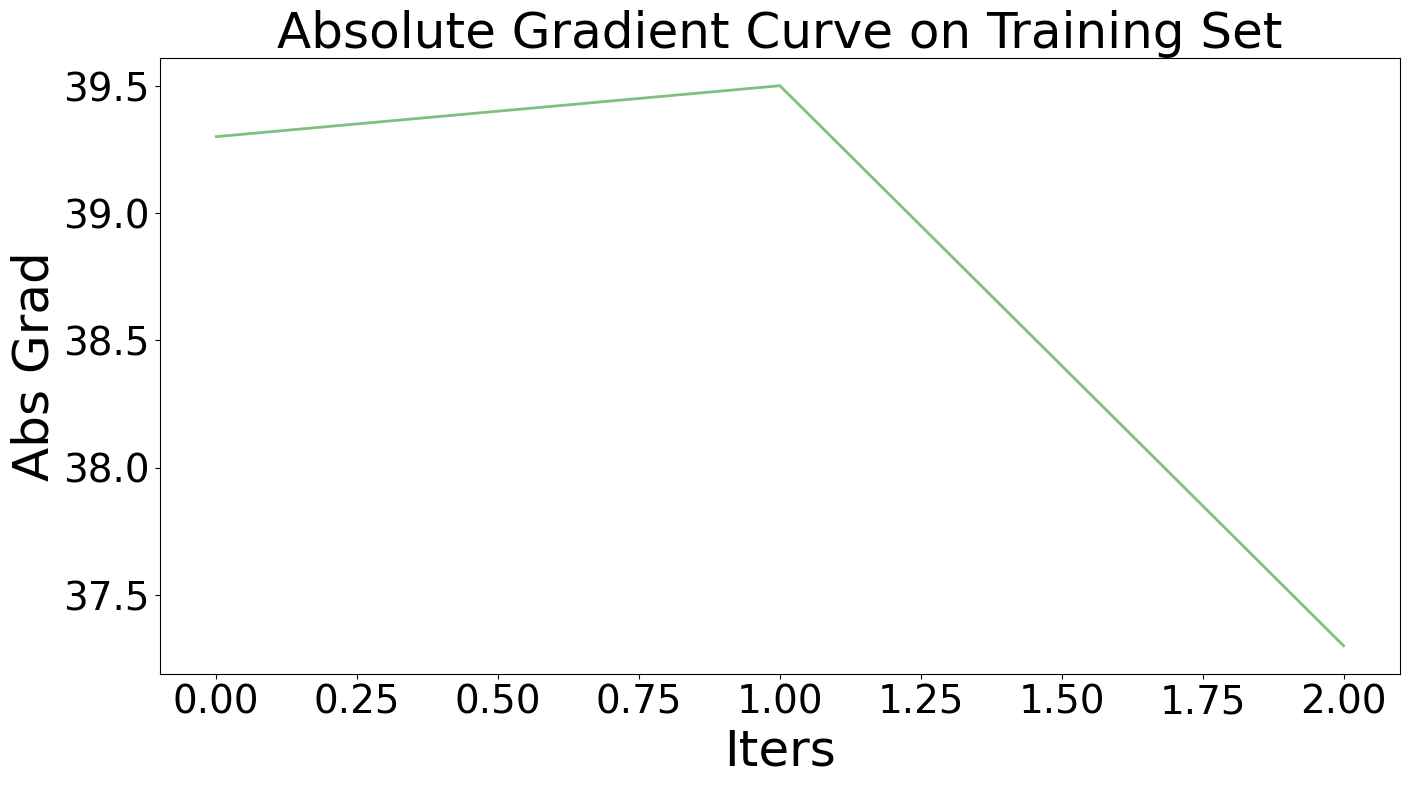

In [47]:
plot(loss_log, grad_log)

### NCE 

In [48]:
# init model
reg = LinearRegression()

In [49]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [50]:
lr = 5e-2
loss_log, grad_log = pipeline(reg, forwardNCE, nce, lr, num_epochs, loader_train, loader_val, loader_test)

Epoch    2, Loss:   0.2145: 100%|████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


Training Elapsed Time: 0.01 Sec

Evaluation:
Test Regret: 110.0804%
Test Elapsed Time: 0.31 Sec


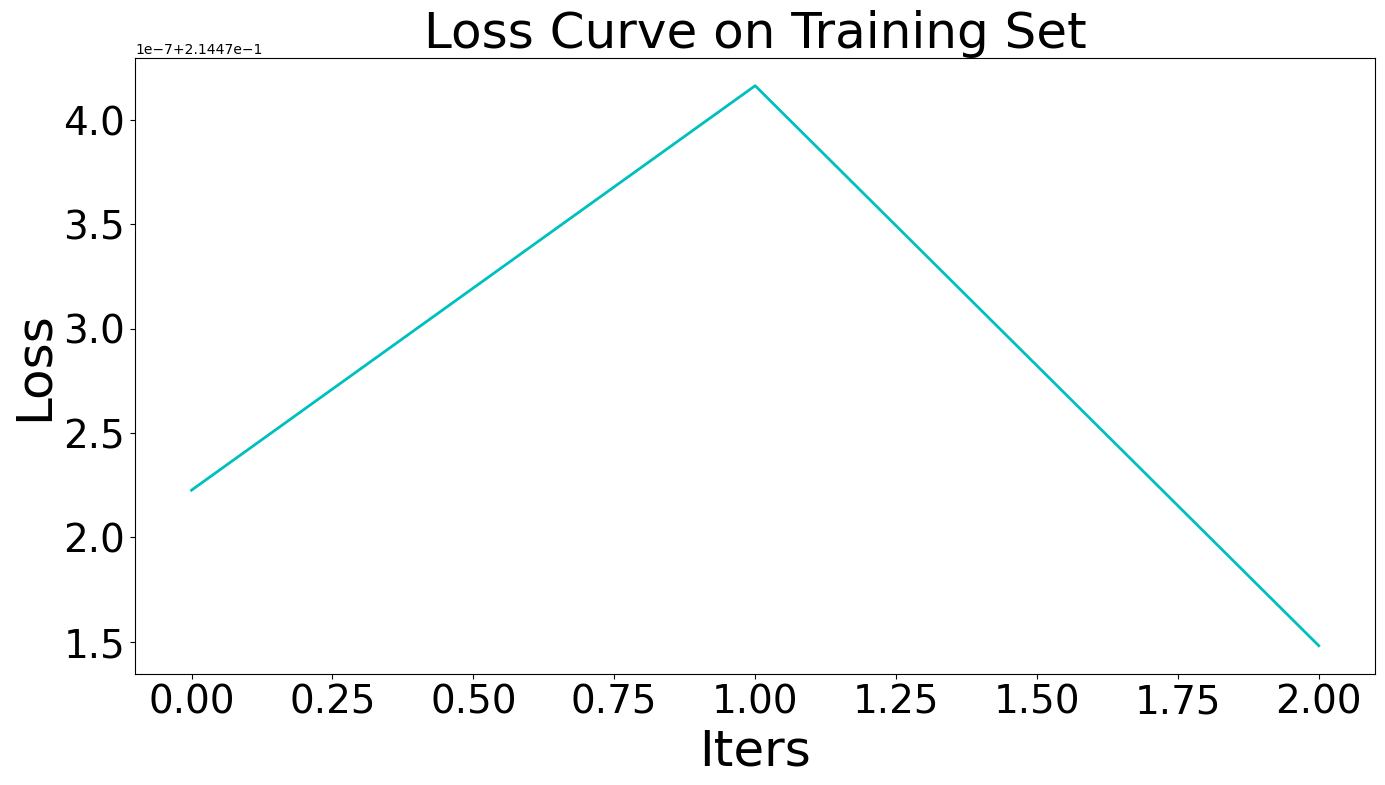

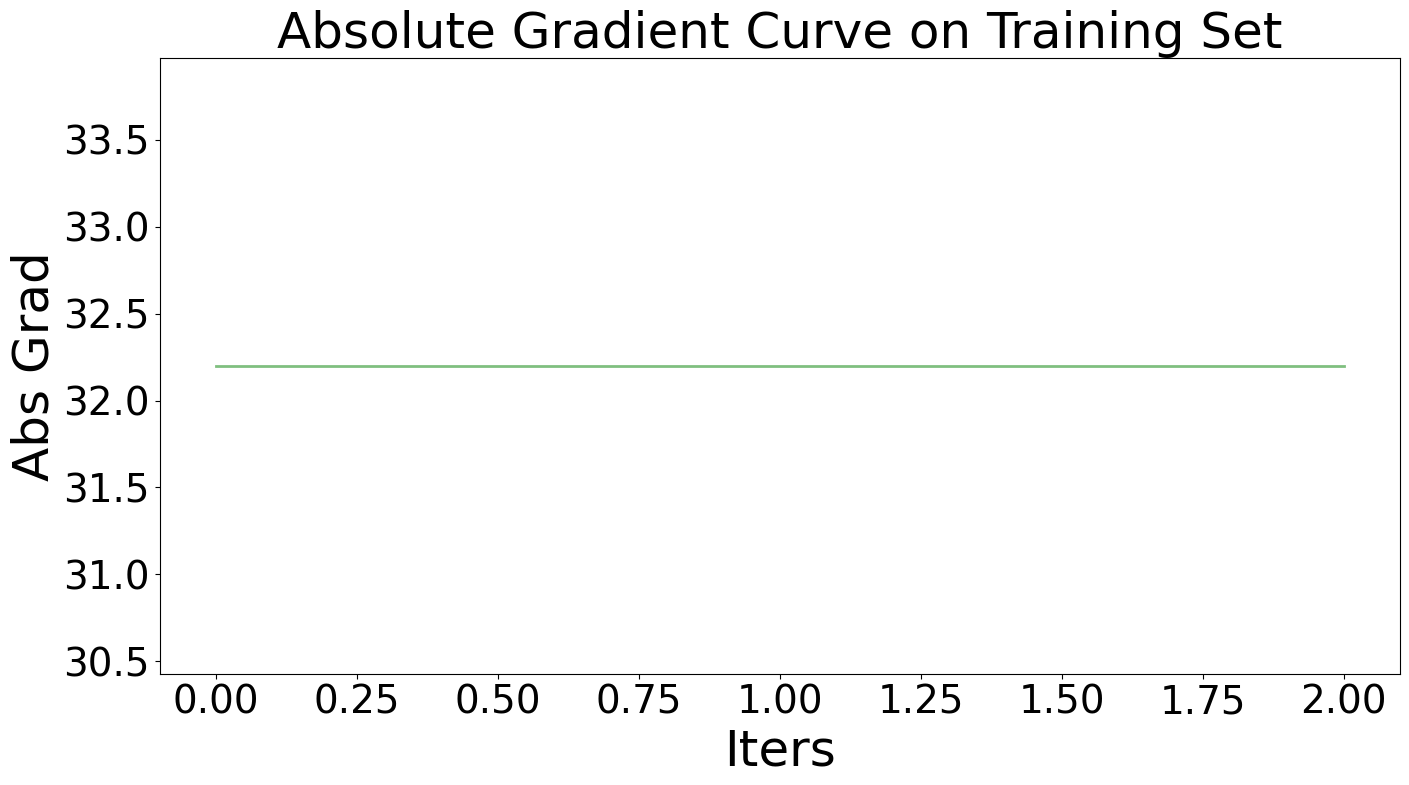

In [51]:
plot(loss_log, grad_log)